In [1]:
!git clone https://github.com/cerlymarco/MEDIUM_NoteBook.git

Cloning into 'MEDIUM_NoteBook'...
remote: Enumerating objects: 1248, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 1248 (delta 96), reused 227 (delta 72), pack-reused 951
Receiving objects: 100% (1248/1248), 78.81 MiB | 30.43 MiB/s, done.
Resolving deltas: 100% (469/469), done.


In [2]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

In [21]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [27]:
### LOAD DATA ###

label = pd.read_csv('/content/MEDIUM_NoteBook/Predictive_Maintenance/profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']

data = ['/content/MEDIUM_NoteBook/Predictive_Maintenance/TS1.txt','/content/MEDIUM_NoteBook/Predictive_Maintenance/TS2.txt','/content/MEDIUM_NoteBook/Predictive_Maintenance/TS3.txt','/content/MEDIUM_NoteBook/Predictive_Maintenance/TS4.txt']
df = pd.DataFrame()

for txt in data:
    read_df = pd.read_csv(txt, sep='\t', header=None)
    df = df.append(read_df)    

print(df.shape)
df.head()

(8820, 60)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,35.172,35.168,35.156,35.187,35.176,35.250,35.234,35.316,35.316,35.402,35.402,35.398,35.441,35.414,35.434,35.480,35.500,35.488,35.559,35.555,35.574,35.652,35.668,35.664,35.660,35.734,35.824,35.824,35.820,35.836,35.836,35.828,35.840,35.859,35.918,35.914,35.895,35.992,35.980,35.980,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,35.648,35.734,35.828,35.848,35.902,36.035,36.078,36.199,36.246,36.301,36.398,36.473,36.500,36.555,36.652,36.645,36.664,36.652,36.738,36.715,36.797,36.797,36.891,36.902,36.898,36.984,36.984,37.062,37.051,37.145,37.141,37.172,37.164,37.164,37.152,37.238,37.234,37.305,37.305,37.324,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,36.887,36.887,36.980,37.059,37.137,37.230,37.316,37.398,37.477,37.582,37.578,37.723,37.730,37.730,37.797,37.898,37.980,37.977,37.984,38.016,38.031,38.047,38.117,38.125,38.195,38.219,38.207,38.289,38.301,38.281,38.367,38.379,38.379,38.379,38.379,38.375,38.367,38.391,38.391,38.469,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
3,38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,37.887,37.902,37.965,38.047,38.180,38.203,38.367,38.406,38.457,38.629,38.633,38.699,38.801,38.801,38.828,38.902,38.895,38.969,38.988,39.055,39.055,39.055,39.055,39.121,39.215,39.215,39.219,39.227,39.273,39.285,39.293,39.293,39.273,39.285,39.375,39.359,39.375,39.379,39.367,39.363,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
4,39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,38.809,38.789,38.883,38.965,39.047,39.121,39.234,39.281,39.453,39.461,39.488,39.633,39.723,39.719,39.711,39.801,39.879,39.867,39.883,39.973,39.973,39.961,40.047,40.133,40.047,40.133,40.145,40.230,40.219,40.219,40.305,40.297,40.285,40.309,40.281,40.309,40.391,40.348,40.320,40.336,40.324,40.320,40.312,40.340,40.320,40.387,40.391,40.391,40.387,40.391


In [36]:
read_df12 = pd.read_csv(data[0], sep='\t', header=None)
read_df12


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,35.172,35.168,35.156,35.187,35.176,35.250,35.234,35.316,35.316,35.402,35.402,35.398,35.441,35.414,35.434,35.480,35.500,35.488,35.559,35.555,35.574,35.652,35.668,35.664,35.660,35.734,35.824,35.824,35.820,35.836,35.836,35.828,35.840,35.859,35.918,35.914,35.895,35.992,35.980,35.980,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,35.648,35.734,35.828,35.848,35.902,36.035,36.078,36.199,36.246,36.301,36.398,36.473,36.500,36.555,36.652,36.645,36.664,36.652,36.738,36.715,36.797,36.797,36.891,36.902,36.898,36.984,36.984,37.062,37.051,37.145,37.141,37.172,37.164,37.164,37.152,37.238,37.234,37.305,37.305,37.324,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,36.887,36.887,36.980,37.059,37.137,37.230,37.316,37.398,37.477,37.582,37.578,37.723,37.730,37.730,37.797,37.898,37.980,37.977,37.984,38.016,38.031,38.047,38.117,38.125,38.195,38.219,38.207,38.289,38.301,38.281,38.367,38.379,38.379,38.379,38.379,38.375,38.367,38.391,38.391,38.469,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
3,38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,37.887,37.902,37.965,38.047,38.180,38.203,38.367,38.406,38.457,38.629,38.633,38.699,38.801,38.801,38.828,38.902,38.895,38.969,38.988,39.055,39.055,39.055,39.055,39.121,39.215,39.215,39.219,39.227,39.273,39.285,39.293,39.293,39.273,39.285,39.375,39.359,39.375,39.379,39.367,39.363,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
4,39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,38.809,38.789,38.883,38.965,39.047,39.121,39.234,39.281,39.453,39.461,39.488,39.633,39.723,39.719,39.711,39.801,39.879,39.867,39.883,39.973,39.973,39.961,40.047,40.133,40.047,40.133,40.145,40.230,40.219,40.219,40.305,40.297,40.285,40.309,40.281,40.309,40.391,40.348,40.320,40.336,40.324,40.320,40.312,40.340,40.320,40.387,40.391,40.391,40.387,40.391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,35.414,35.348,35.254,35.262,35.168,35.172,35.105,35.094,35.000,35.008,35.012,35.066,35.062,35.090,35.160,35.145,35.168,35.156,35.168,35.199,35.238,35.242,35.242,35.250,35.262,35.320,35.344,35.320,35.336,35.410,35.332,35.414,35.422,35.410,35.426,35.434,35.441,35.426,35.441,35.434,35.488,35.422,35.414,35.437,35.410,35.414,35.492,35.426,35.422,35.410,35.426,35.516,35.437,35.426,35.410,35.414,35.414,35.426,35.414,35.414
2201,35.434,35.332,35.266,35.195,35.262,35.195,35.082,35.105,34.988,35.008,35.023,35.090,35.105,35.117,35.176,35.176,35.184,35.172,35.250,35.187,35.250,35.242,35.266,35.277,35.250,35.355,35.348,35.348,35.348,35.336,35.344,35.422,35.422,35.402,35.422,35.434,35.422,35.437,35.437,35.414,35.516,35.480,35.488,35.414,35.414,35.434,35.437,35.426,35.426,35.508,35.434,35.434,35.449,35.414,35.422,35.414,35.426,35.437,35.402,35.398
2202,35.434,35.355,35.262,35.187,35.266,35.102,35.105,35.094,35.016,35.016,34.984,35.016,35.090,35.074,35.168,35.160,35.184,35.172,35.195,35.250,35.176,35.160,35.262,35.262,35.281,35.250,35.254,35.336,35.320,35.437,35.344,35.434,35.434,35.437,35.441,35.441,35.437,35.434,35.508,35.480,35.508,35.402,35.414,35.449,35.441,35.441,35.492,35.520,35.449,35.414,35.500,35.434,35.410,35.434,35.426,35.437,35.441,35.410,35.434,35.437
2203,35.449,35.359,35.277,35.184,35.195,35.184,35.105,35.016,35.012,35.008,35.000,35.078,35.000,35.078,35.102,35.172,35.168,35.176,35.168,35.277,35.262,35.176,35.270,35.262,35.266,35.336,35.242,35.336

In [29]:
### RESHAPE DATA AMONG SENSORS ###

df = df.sort_index().values.reshape(-1,len(data),len(df.columns)).transpose(0,2,1)
df.shape

(2205, 60, 4)

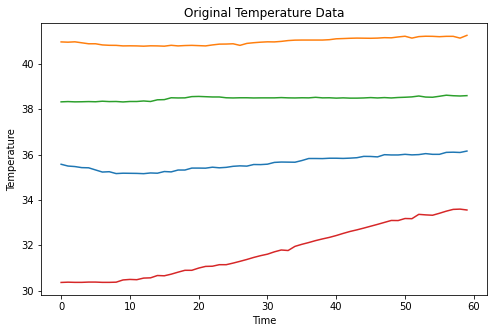

In [32]:
### PLOT ORIGINAL TEMPERATURE DATA ###

plt.figure(figsize=(8,5))
plt.plot(df[0])
plt.title('Original Temperature Data')
plt.ylabel('Temperature'); plt.xlabel('Time')
np.set_printoptions(False)

In [7]:
### LABEL DISTRIBUTION ###

label = label.Cooler
label.value_counts()

100    741
3      732
20     732
Name: Cooler, dtype: int64

In [8]:
### MAPPING LABEL ###

diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = to_categorical(label)

{3: 0, 20: 1, 100: 2}
{0: 3, 1: 20, 2: 100}


In [9]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state = 42, test_size=0.2)

In [10]:
### SCALE DATA ###

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# MODEL

In [11]:
num_sensors = 4
TIME_PERIODS = 60
BATCH_SIZE = 16
EPOCHS = 10

model_m = Sequential()
model_m.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 6, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_m.add(Dropout(0.5))
model_m.add(Dense(3, activation='softmax'))

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_m.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

Epoch 1/10
89/89 - 4s - loss: 0.1920 - accuracy: 0.9405 - val_loss: 0.0823 - val_accuracy: 0.9773
Epoch 2/10
89/89 - 2s - loss: 0.1100 - accuracy: 0.9766 - val_loss: 0.0696 - val_accuracy: 0.9802
Epoch 3/10
89/89 - 2s - loss: 0.1066 - accuracy: 0.9766 - val_loss: 0.0941 - val_accuracy: 0.9802
Epoch 4/10
89/89 - 2s - loss: 0.1310 - accuracy: 0.9745 - val_loss: 0.0663 - val_accuracy: 0.9773
Epoch 5/10
89/89 - 2s - loss: 0.1105 - accuracy: 0.9738 - val_loss: 0.0699 - val_accuracy: 0.9773
Epoch 6/10
89/89 - 2s - loss: 0.1181 - accuracy: 0.9717 - val_loss: 0.0834 - val_accuracy: 0.9802
Epoch 7/10
89/89 - 2s - loss: 0.1025 - accuracy: 0.9794 - val_loss: 0.0644 - val_accuracy: 0.9830
Epoch 8/10
89/89 - 2s - loss: 0.0970 - accuracy: 0.9752 - val_loss: 0.0599 - val_accuracy: 0.9802
Epoch 9/10
89/89 - 2s - loss: 0.0906 - accuracy: 0.9787 - val_loss: 0.0903 - val_accuracy: 0.9802
Epoch 10/10
89/89 - 2s - loss: 0.1009 - accuracy: 0.9794 - val_loss: 0.0768 - val_accuracy: 0.9858


In [12]:
model_m.evaluate(X_test, y_test, verbose=2)

14/14 - 0s - loss: 0.1304 - accuracy: 0.9841


[0.130386620759964, 0.9841269850730896]

In [53]:
y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [41]:
### GET PREDICTED CLASS ###

pred_test = np.argmax(model_m.predict(X_test), axis=1)

In [58]:
y_pred=model_m.predict(X_test)

In [42]:
print(classification_report([diz_reverse_label[np.argmax(label)] for label in y_test], 
                            [diz_reverse_label[label] for label in pred_test]))

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       152
          20       0.96      0.99      0.97       135
         100       1.00      0.98      0.99       154

    accuracy                           0.98       441
   macro avg       0.98      0.98      0.98       441
weighted avg       0.98      0.98      0.98       441



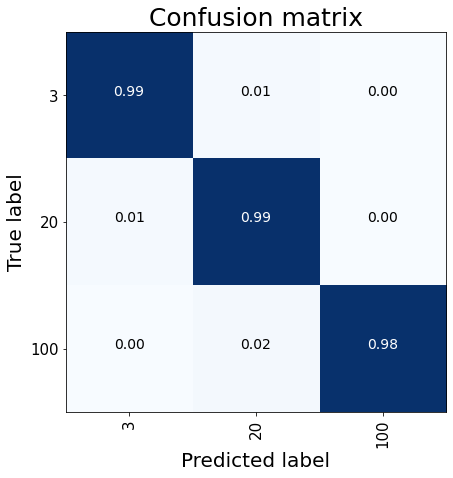

In [43]:
cnf_matrix = confusion_matrix([diz_reverse_label[np.argmax(label)] for label in y_test], 
                              [diz_reverse_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_reverse_label.values()))
plt.show()

# VISUAL REPRESENTATION

In [16]:
### MAKE A MODEL FOR EMBEDDINGS ###
emb_model = Model(inputs=model_m.input, outputs=model_m.get_layer('G_A_P_1D').output)
emb_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 60, 4)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 100)           2500      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 100)           60100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 160)           96160     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 160)            153760    
_________________________________________________________________
G_A_P_1D (GlobalAveragePooli (None, 160)               0     

In [51]:
### EXTRACT EMBEDDINGS ###
serie_features = emb_model.predict(X_test)

In [52]:
serie_features.shape

(441, 160)

In [50]:
### VISUALIZE EMBEDDINGS ###
tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T = tsne.fit_transform(serie_features)
T.T[1].shape

(441,)

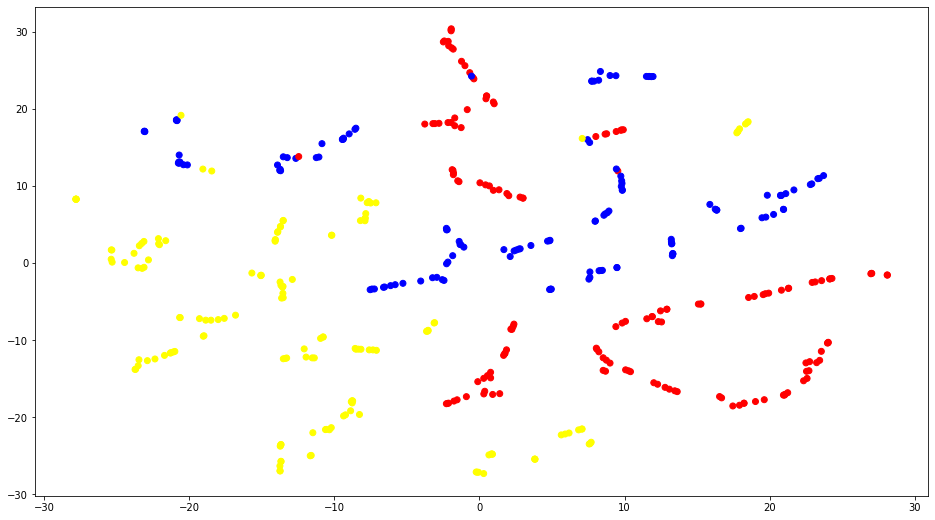

In [19]:
plt.figure(figsize=(16,9))
colors = {0:'red', 1:'blue', 2:'yellow'}
plt.scatter(T.T[0], T.T[1], c=[colors[i] for i in np.argmax(y_test, axis=1)]) 
plt.show()